# Performance of LLMs on the MMLU benchmark
This notebook examines the performance of various large language models (LLMs) on the MMLU dataset.

Hugging Face dataset: https://huggingface.co/datasets/cais/mmlu 
* We use the following subsets of MMLU: 

```
MMLU_SUBSETS = [
    "anatomy", "college_biology", "college_medicine", "high_school_biology", 
    "medical_genetics", "professional_medicine", "virology"
]
```

Paper: https://arxiv.org/abs/2009.03300

## Setup

In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from datetime import datetime

In [2]:
results_df_path = 'results.csv'

log_files_dir = 'logs/'
models_data_file = '../../models/models_data.tsv'

large_scale_models_file = '../../models/epoch-data/large_scale_ai_models.csv'
notable_models_file = '../../models/epoch-data/notable_ai_models.csv'

## Process metadata
First, we merge two Epoch datasets containing model metadata into a single dataframe. 

[1] https://epochai.org/data/large-scale-ai-models  
[2] https://epochai.org/data/notable-ai-models

In [3]:
def merge_epoch_datasets(notable_file, large_scale_file):
    """"""
    
    notable_df = pd.read_csv(notable_file)
    large_scale_df = pd.read_csv(large_scale_file)
    epoch_df = pd.concat([notable_df, large_scale_df], ignore_index=True)
    epoch_df = epoch_df.drop_duplicates(subset='System', keep='first')
    return epoch_df

epoch_data = merge_epoch_datasets(notable_models_file, large_scale_models_file)

print(f"Total number of models in epoch data: {len(epoch_data)}")
epoch_data.head()

Total number of models in epoch data: 959


,System,Domain,Organization,Authors,Publication date,Reference,Link,Notability criteria,Notability criteria notes,Training dataset notes,...,Base model,Finetune compute (FLOP),Finetune compute notes,Compute cost notes,Training compute cost (2023 USD),Task,Organization categorization (from Organization),Training code accessibility,Dataset accessibility,Accessibility notes
0,AFM-server,Language,Apple,"Andy Narayanan, Aonan Zhang, Bowen Zhang, Chen...",2024-07-29,Apple Intelligence Foundation Language Models,https://machinelearning.apple.com/research/app...,Significant use,"Currently in beta access only, but will be int...","6.3T tokens of web text, code, and math, plus ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFM-on-device,Language,Apple,"Andy Narayanan, Aonan Zhang, Bowen Zhang, Chen...",2024-07-29,Apple Intelligence Foundation Language Models,https://machinelearning.apple.com/research/app...,Significant use,"Currently in beta access only, but will be int...",188B of tokens are used to train a pruning mas...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Llama 3.1-405B,Language,Meta AI,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...",2024-07-23,The Llama 3 Herd of Models,https://ai.meta.com/research/publications/the-...,"SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ESM3 (98B),Biology,"EvolutionaryScale,UC Berkeley","Thomas Hayes, Roshan Rao, Halil Akin, Nicholas...",2024-06-25,ESM3: Simulating 500 million years of evolutio...,https://www.evolutionaryscale.ai/blog/esm3-rel...,Historical significance,Largest (in compute) biology and protein model...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Claude 3.5 Sonnet,"Multimodal,Language,Vision",Anthropic,NaN,2024-06-20,Claude 3.5 Sonnet,https://www-cdn.anthropic.com/fed9cc193a14b841...,"Significant use,SOTA improvement","""It also sets new performance standards in eva...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we load data I personally compiled, which contains cost per M tokens and creates a mapping between the Epoch and Inspect model names. This gets merged with the Epoch data to make our complete metadata table.

In [4]:
models_df = pd.read_csv(models_data_file, sep='\t')

models_metadata = models_df.merge(epoch_data, left_on='epoch_model_name', right_on='System', how='left')
models_metadata.head()

,inspect_model_name,epoch_model_name,biggest_in_class,cost_per_M_tokens,input_cost_per_M_tokens,output_cost_per_M_tokens,cost_source,api_source,last_updated,Unnamed: 9,...,Base model,Finetune compute (FLOP),Finetune compute notes,Compute cost notes,Training compute cost (2023 USD),Task,Organization categorization (from Organization),Training code accessibility,Dataset accessibility,Accessibility notes
0,google/gemini-1.5-flash,NaN,0,NaN,$0.08,$0.30,https://ai.google.dev/pricing,https://ai.google.dev/gemini-api/docs/models/g...,2024-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,google/gemini-1.5-pro,Gemini 1.5 Pro,1,NaN,$3.50,$10.50,https://ai.google.dev/pricing,https://ai.google.dev/gemini-api/docs/models/g...,2024-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,google/gemini-1.0-pro,Gemini 1.0 Pro,1,NaN,$0.50,$1.50,https://ai.google.dev/pricing,https://ai.google.dev/gemini-api/docs/models/g...,2024-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,openai/gpt-4,GPT-4,1,NaN,$30.00,$60.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03,NaN,...,NaN,NaN,NaN,NaN,4.058659e+07,NaN,NaN,NaN,NaN,NaN
4,openai/gpt-4-turbo,GPT-4 Turbo,1,NaN,$10.00,$30.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load results from Inspect
Load the contents of a log directory into a dataframe

In [5]:
def process_log_files(log_files_dir):
    results = []
    
    for filename in os.listdir(log_files_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(log_files_dir, filename)
            with open(file_path, 'r') as f:
                log = json.load(f)
            
            if log['status'] == "success":
                model_name = log['eval']['model']
                
                # Extract data from logs
                accuracy = next((score['metrics']['accuracy']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                stderr = next((score['metrics']['stderr']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                token_usage = sum(usage['total_tokens'] for usage in log['stats']['model_usage'].values())
                task_name = log['eval']['task']
                dataset_samples = log['eval']['dataset']['samples']
                completed_samples = log['results']['completed_samples']
                input_tokens = sum(usage['input_tokens'] for usage in log['stats']['model_usage'].values())
                output_tokens = sum(usage['output_tokens'] for usage in log['stats']['model_usage'].values())
                start_time = log['stats']['started_at']
                end_time = log['stats']['completed_at']
                task_attribs = log['eval']['task_attribs']
                category = task_attribs.get('category')
                difficulty = task_attribs.get('difficulty')
                
                results.append({
                    'inspect_model_name': model_name,
                    'accuracy': accuracy,
                    'stderr': stderr,
                    'total_tokens': token_usage,
                    'input_tokens': input_tokens,
                    'output_tokens': output_tokens,
                    'task': task_name,
                    'dataset_samples': dataset_samples,
                    'completed_samples': completed_samples,
                    'run_id': log['eval']['run_id'],
                    'created': log['eval']['created'],
                    'start_time': start_time,
                    'end_time': end_time,
                    'category': category,
                    'difficulty': difficulty,
                    'filename': filename
                })
    
    return pd.DataFrame(results)

results_df = process_log_files(log_files_dir)

Finally, merge the model metadata with the Inspect results

In [6]:
mmlu_df = results_df.merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

# Identify unmatched models
unmatched_models = mmlu_df[mmlu_df['epoch_model_name'].isna()]['inspect_model_name'].unique()
print("Models from Inspect results without Epoch metadata", unmatched_models)
mmlu_df.head()

Models from Inspect results without Epoch metadata ['google/gemini-1.5-flash']


,inspect_model_name,accuracy,stderr,total_tokens,input_tokens,output_tokens,task,dataset_samples,completed_samples,run_id,...,Base model,Finetune compute (FLOP),Finetune compute notes,Compute cost notes,Training compute cost (2023 USD),Task,Organization categorization (from Organization),Training code accessibility,Dataset accessibility,Accessibility notes
0,together/meta-llama/Llama-2-13b-chat-hf,0.487692,0.013869,241131,226968,14163,benchmarks/run,1300,1300,jpjEnDfqziRVZGioaggPiy,...,NaN,NaN,NaN,NaN,NaN,Language modelling,Industry,Unreleased,NaN,Llama 2 license. can't use outputs to train mo...
1,together/meta-llama/Meta-Llama-3-70B-Instruct-...,0.824615,0.010552,197342,190827,6515,benchmarks/run,1300,1300,Fzz3XWBaJbS9dRFWb9Yxar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mistral/mistral-large-2407,0.836923,0.010250,218655,212155,6500,benchmarks/run,1300,1300,5zzFSR2PFfn49WvATjvZ5L,...,NaN,NaN,NaN,NaN,NaN,"Language modelling/generation,Translation,Code...",Industry,Unreleased,NaN,"""We are releasing Mistral Large 2 under the Mi..."
3,anthropic/claude-instant-1.2,0.687692,0.012858,208819,198419,10400,benchmarks/run,1300,1300,PfVGYcP2vtiFw8Vb7rPvF3,...,NaN,NaN,NaN,NaN,NaN,"Language modelling,Chat",Industry,Unreleased,NaN,NaN
4,openai/gpt-4-turbo,0.863077,0.009538,191179,185690,5489,benchmarks/run,1300,1300,8Mmk5Wnmif5kPXYU5BwAY3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cost analysis

In [7]:
def clean_cost(value):
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        return float(value.replace('$', '').replace(',', ''))
    return float(value)

def calculate_cost(row):
    input_cost_per_M = clean_cost(row['input_cost_per_M_tokens'])
    output_cost_per_M = clean_cost(row['output_cost_per_M_tokens'])
    cost_per_M = clean_cost(row['cost_per_M_tokens'])
    
    if input_cost_per_M and output_cost_per_M:
        input_cost = (input_cost_per_M / 1_000_000) * row['input_tokens']
        output_cost = (output_cost_per_M / 1_000_000) * row['output_tokens']
        return input_cost + output_cost
    elif cost_per_M:
        return (cost_per_M / 1_000_000) * row['total_tokens']
    else:
        return 0
    
# Calculate cost for each run
mmlu_df['cost'] = mmlu_df.apply(calculate_cost, axis=1)
mmlu_df.to_csv(results_df_path)

total_cost = mmlu_df['cost'].sum()
print(f"Estimated total cost of GPQA benchmark run: ${total_cost:.2f}")

Estimated total cost of GPQA benchmark run: $23.90


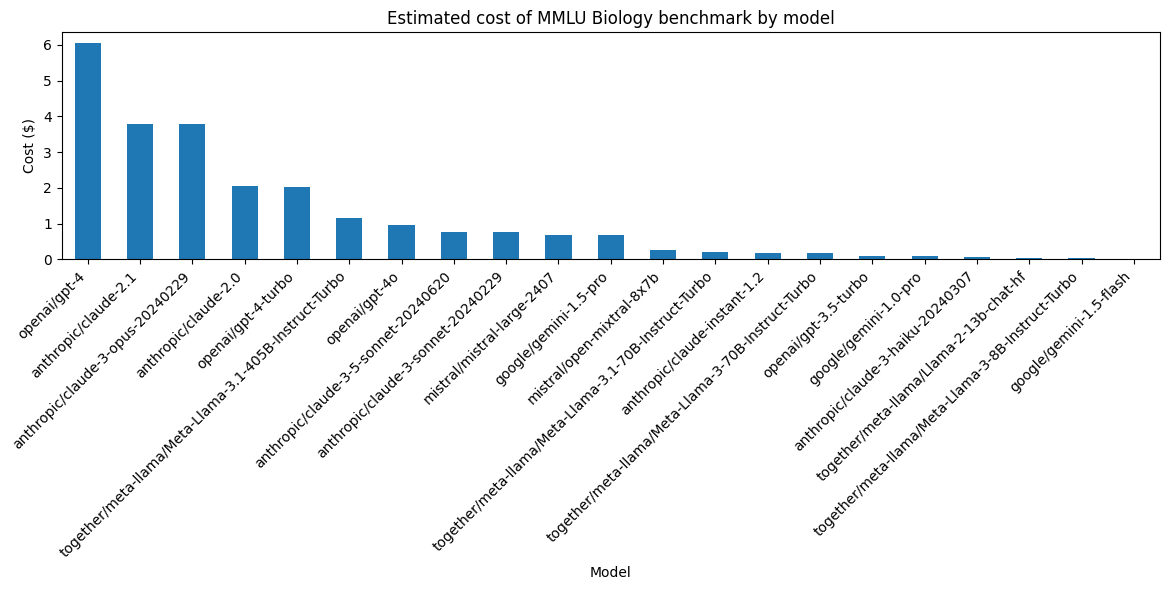

In [8]:
# Cost breakdown by model
model_costs = mmlu_df.groupby('inspect_model_name')['cost'].sum().sort_values(ascending=False)

# Create a bar plot of costs by model
plt.figure(figsize=(12, 6))
model_costs.plot(kind='bar')
plt.title("Estimated cost of MMLU Biology benchmark by model")
plt.xlabel("Model")
plt.ylabel("Cost ($)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Model performance on MMLU over time

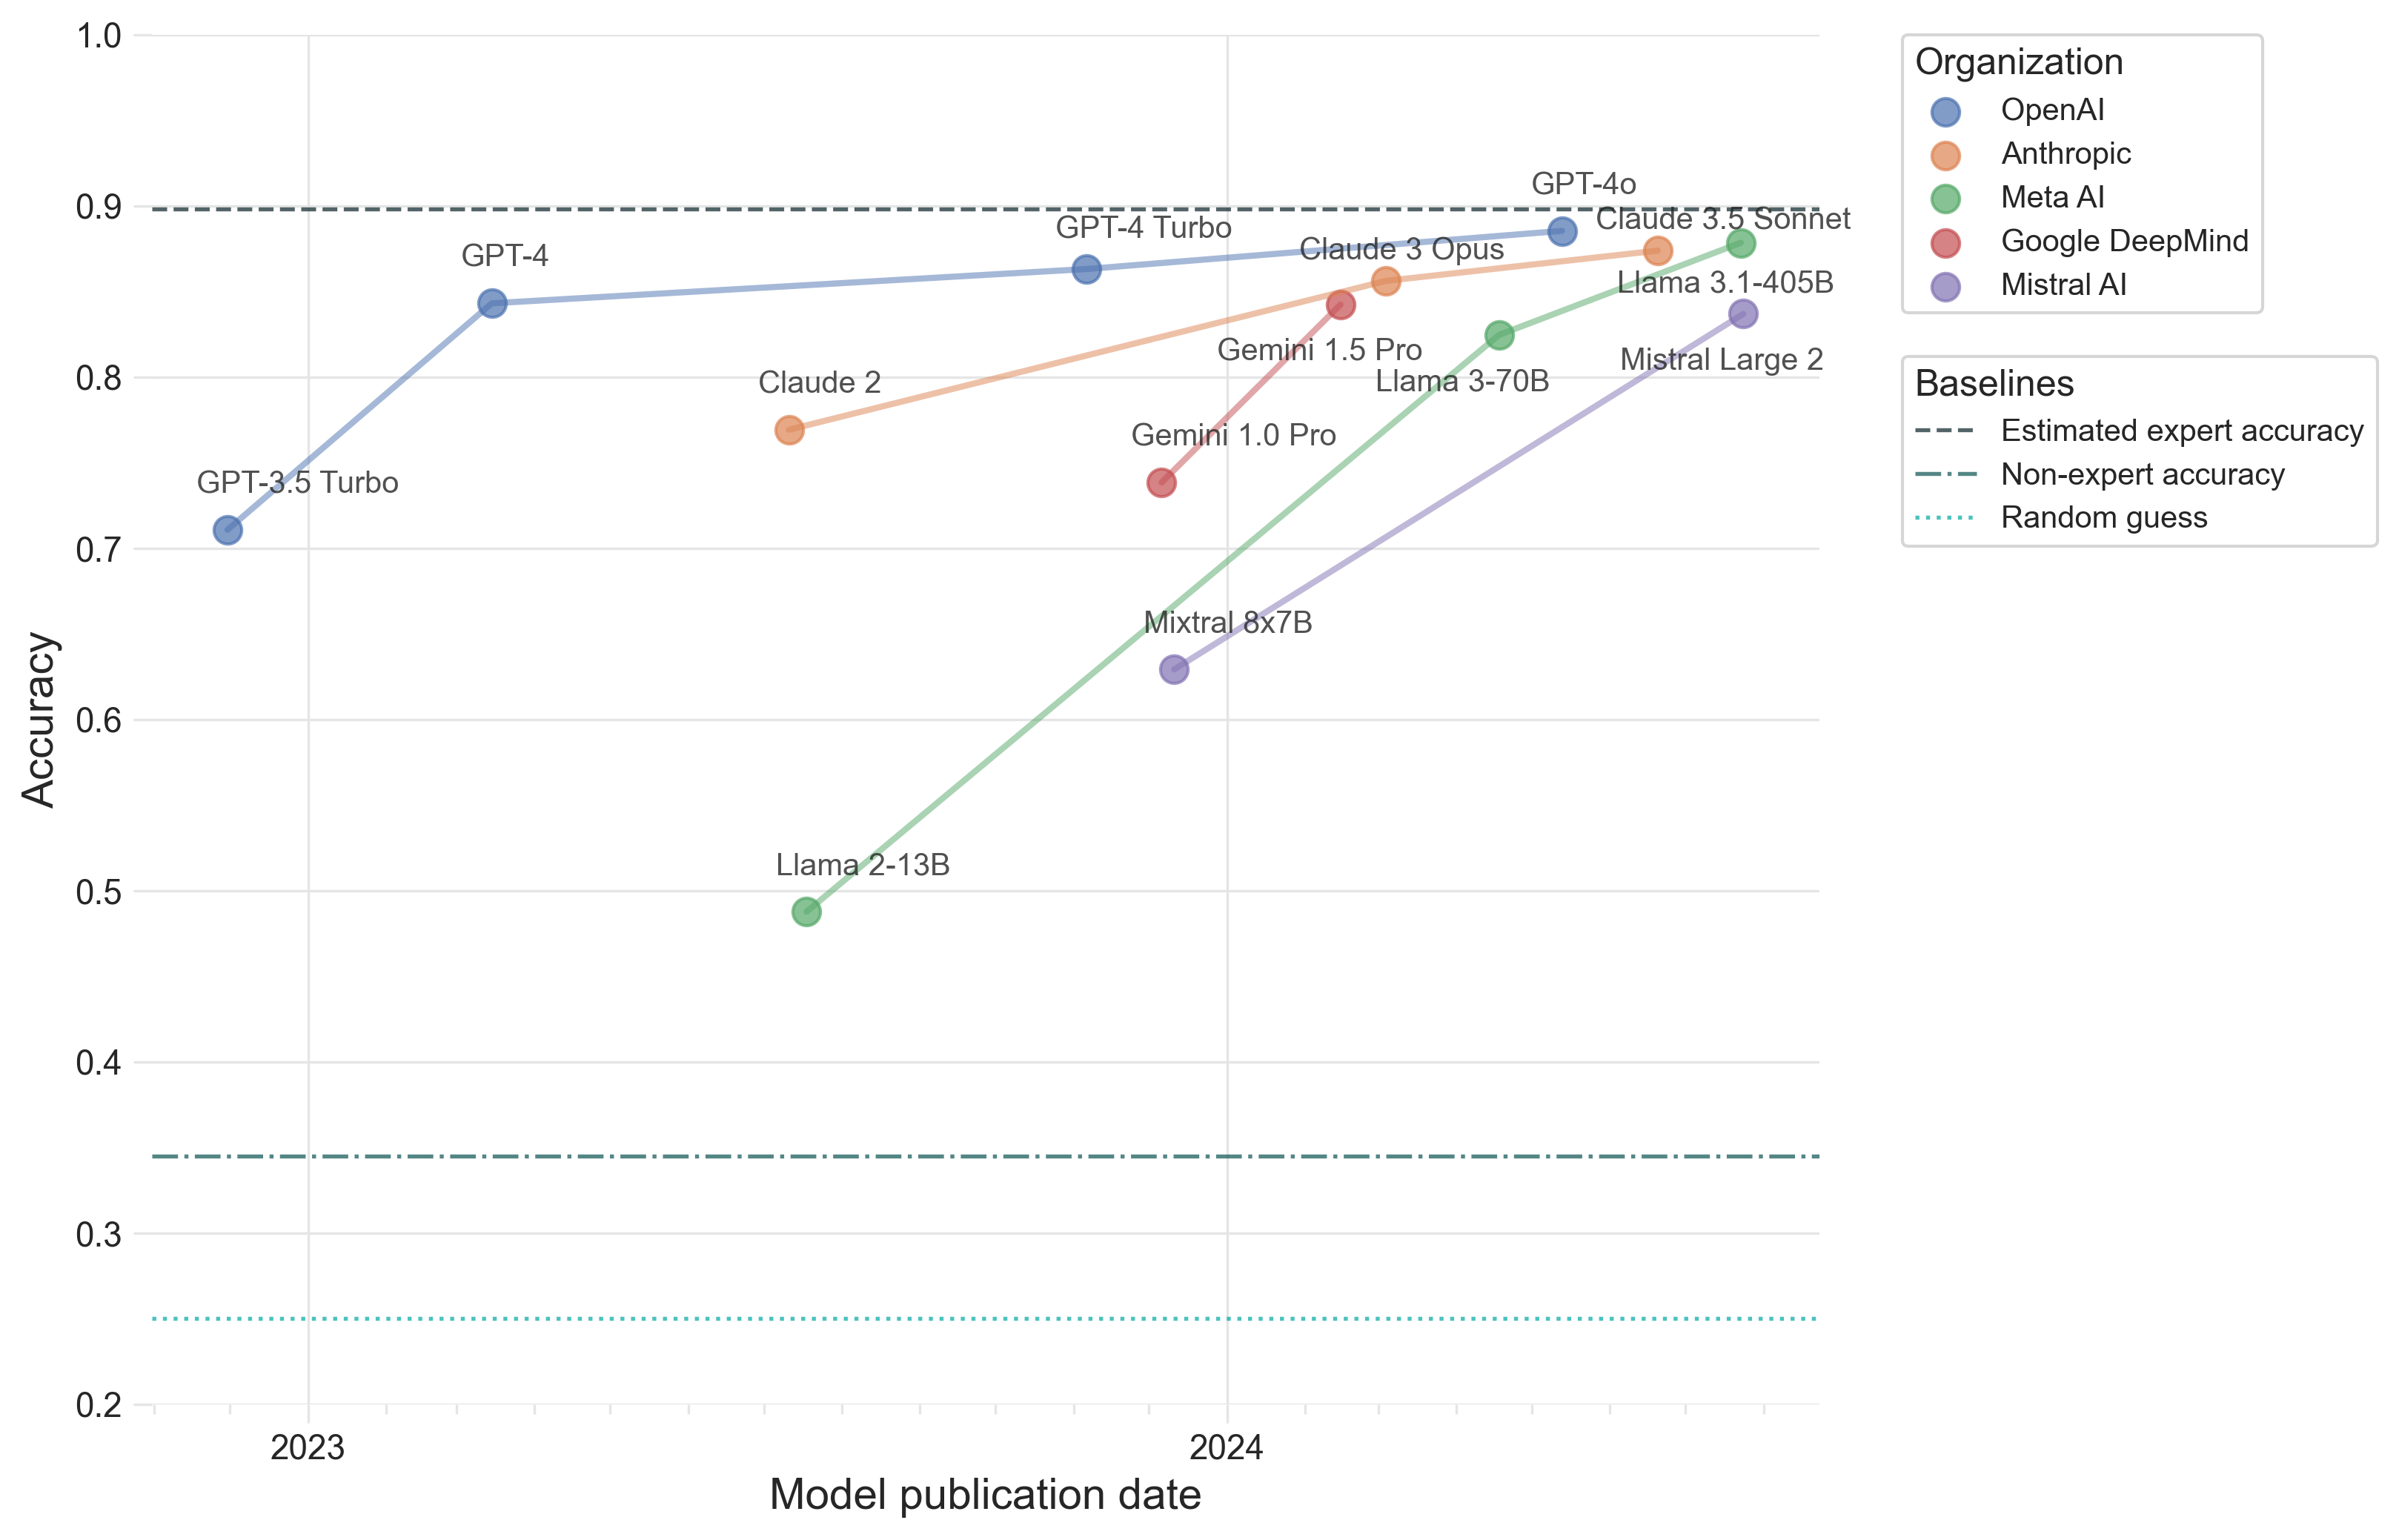

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

# Function to parse dates
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, "%Y-%m-%d")
    except:
        return None

# Prepare the data
plot_data = mmlu_df.copy()
plot_data['Publication date'] = plot_data['Publication date'].apply(parse_date)
plot_data['accuracy'] = plot_data['accuracy'].astype(float)
plot_data['stderr'] = plot_data['stderr'].astype(float)

# Filter for models with biggest_in_class = 1
largest_models = plot_data[plot_data['biggest_in_class'] == 1].sort_values('Publication date')

manual_offsets = {
    "GPT-3.5 Turbo": (-10, 10),
    "GPT-4": (-10, 10),
    "GPT-4 Turbo": (-10, 8),
    "GPT-4o": (-10, 10),
    "Claude 2": (-10, 10),
    "Claude 3 Opus": (-28, 5),
    "Claude 3.5 Sonnet": (-20, 5),
    "Llama 2-13B": (-10, 10),
    "Llama 3-70B": (-40, -20),
    "Llama 3.1-405B": (-40, -18),
    "Gemini 1.0 Pro": (-10, 10),
    "Gemini 1.5 Pro": (-40, -20),
    "Mixtral 8x7B": (-10, 10),
    "Mistral Large 2": (-40, -20)
}

# Set plot style for publication-quality figure
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['axes.edgecolor'] = 'gray'

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("deep")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create a color map for organizations
organizations = largest_models['Organization'].unique()
color_map = dict(zip(organizations, sns.color_palette("deep", len(organizations))))

# Plot the data
for org in organizations:
    org_data = largest_models[largest_models['Organization'] == org]
    ax.scatter(org_data['Publication date'], org_data['accuracy'], 
               label=org, color=color_map[org], s=80, alpha=0.7)
    ax.plot(org_data['Publication date'], org_data['accuracy'], linewidth=2,
            color=color_map[org], alpha=0.5)
    
    for _, row in org_data.iterrows():
        offset = manual_offsets.get(row['epoch_model_name'], (5, 5))
        ax.annotate(row['epoch_model_name'], 
                    (row['Publication date'], row['accuracy']),
                    xytext=offset, textcoords='offset points',
                    fontsize=10, alpha=0.8, rotation=0, ha='left', va='bottom')

# Add reference lines with colorblind-friendly colors and styles
ax.axhline(y=0.898, color='#092327', linestyle='--', alpha=0.7, linewidth=1.3, label='Estimated expert accuracy')
ax.axhline(y=0.345, color='#0b5351', linestyle='-.', alpha=0.7, linewidth=1.3, label='Non-expert accuracy')
ax.axhline(y=0.25, color='#00a9a5', linestyle=':', alpha=0.7, linewidth=1.3, label='Random guess')

# Customize the plot
# ax.set_title("Model Performance on MMLU-Biology Benchmark", fontsize=16, fontweight='bold')
ax.set_xlabel("Model publication date", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_ylim(0.2, 1)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Adjust grid properties
ax.grid(True, axis='both', color='#E5E5E5', linestyle='-', linewidth=0.8, alpha=1)
ax.grid(True, axis='x', which='major', color='#E5E5E5', linestyle='-', linewidth=0.8, alpha=1)
ax.grid(False, axis='x', which='minor')  # Turn off minor x grid

# Customize tick parameters
ax.tick_params(which='major', length=6, width=0.8, color='#E5E5E5', direction='out')
ax.tick_params(which='minor', length=3, width=0.8, color='#E5E5E5', direction='out')

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Make sure both major and minor ticks are visible
ax.tick_params(which='both', bottom=True, top=False, left=True, right=False)

# Remove labels for minor ticks (months)
ax.xaxis.set_tick_params(which='minor', bottom=True, top=False, labelbottom=False)

# Rotate and align the tick labels so they look better
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

# Create two separate legends
# Legend for organizations
org_handles, org_labels = ax.get_legend_handles_labels()
org_legend = ax.legend(org_handles[:len(organizations)], org_labels[:len(organizations)], 
                       title="Organization", title_fontsize='12', fontsize='10', 
                       loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
org_legend._legend_box.align = "left"

# Add the first legend manually
ax.add_artist(org_legend)

# Legend for baselines
baseline_handles = org_handles[len(organizations):]
baseline_labels = org_labels[len(organizations):]
baseline_legend = ax.legend(baseline_handles, baseline_labels, 
                            title="Baselines", title_fontsize='12', fontsize='10', 
                            loc='upper left', bbox_to_anchor=(1.05, 0.765), borderaxespad=0.)
baseline_legend._legend_box.align = "left"

# Adjust layout to make room for legends
plt.subplots_adjust(right=0.75)

# Save the figure
plt.savefig('mmlu-performance-vs-time.png', dpi=300, bbox_inches='tight')
plt.show()

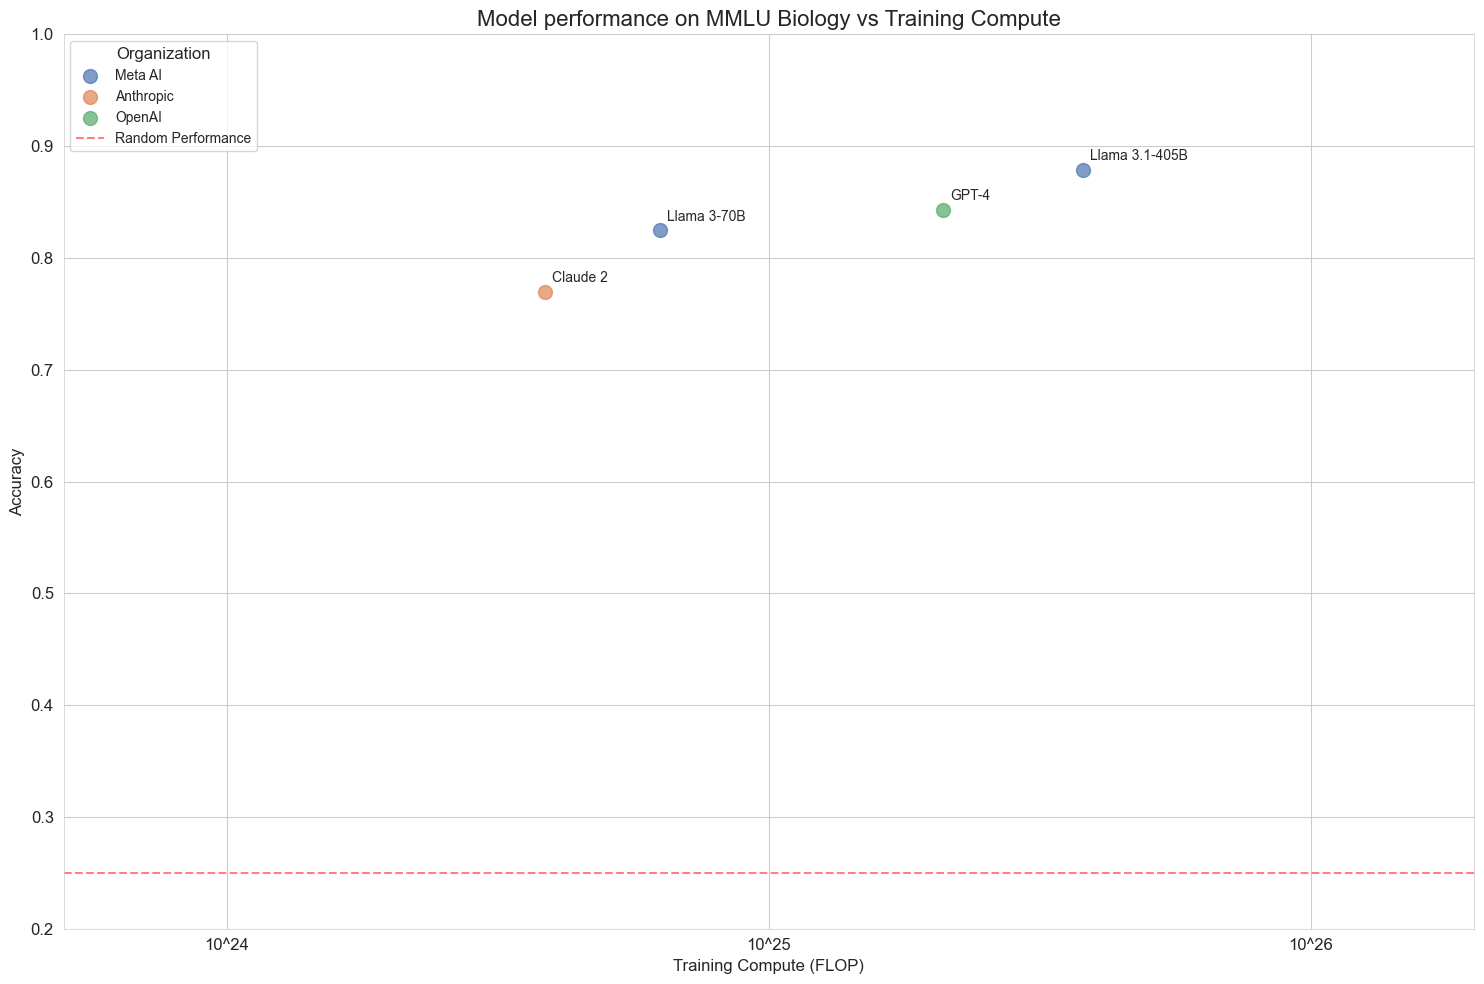

In [58]:
# Prepare the data
plot_data = mmlu_df.copy()
plot_data = plot_data[plot_data['inspect_model_name'] != 'together/meta-llama/Llama-2-70b-hf']
plot_data['accuracy'] = plot_data['accuracy'].astype(float)
plot_data['stderr'] = plot_data['stderr'].astype(float)
plot_data['Training compute (FLOP)'] = plot_data['Training compute (FLOP)'].astype(float)

# Filter for models with biggest_in_class = 1 and non-null training compute
largest_models = plot_data[
    (plot_data['biggest_in_class'] == 1) & 
    (plot_data['Training compute (FLOP)'].notnull())
].sort_values('Training compute (FLOP)')

# Set up the plot style
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create a color map for organizations
organizations = largest_models['Organization'].unique()
color_map = dict(zip(organizations, sns.color_palette("deep", len(organizations))))

# Plot the data
for org in organizations:
    org_data = largest_models[largest_models['Organization'] == org]
    plt.scatter(org_data['Training compute (FLOP)'], org_data['accuracy'], 
                label=org, color=color_map[org], s=100, alpha=0.7)
    
    # Add model names as labels
    for _, row in org_data.iterrows():
        plt.annotate(row['epoch_model_name'], 
                     (row['Training compute (FLOP)'], row['accuracy']),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=10, alpha=1, rotation=0, ha='left', va='bottom')

# Add random performance line
plt.axhline(y=0.25, color='r', linestyle='--', alpha=0.5, label='Random Performance')

# Customize the plot
plt.title("Model performance on MMLU Biology vs Training Compute", fontsize=16)
plt.xlabel("Training Compute (FLOP)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(title="Organization", title_fontsize='12', fontsize='10', loc='upper left')
plt.ylim(0.2, 1)

# Set x-axis to log scale and define custom ticks with padding
plt.xscale('log')
plt.xlim(5e23, 2e26)  # Add padding on both sides
plt.xticks([1e24, 1e25, 1e26], ['10^24', '10^25', '10^26'])

# Adjust layout and display
plt.tight_layout()
plt.savefig('mmlu-biology-performance-vs-compute.png', dpi=300)
plt.show()